In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('world_tourism_economy_data.csv')

In [3]:
df.shape

(6650, 11)

In [4]:
df.dtypes

country                     str
country_code                str
year                      int64
tourism_receipts        float64
tourism_arrivals        float64
tourism_exports         float64
tourism_departures      float64
tourism_expenditures    float64
gdp                     float64
inflation               float64
unemployment            float64
dtype: object

In [5]:
df.isna().sum()

country                    0
country_code               0
year                       0
tourism_receipts        2361
tourism_arrivals        1701
tourism_exports         2536
tourism_departures      4061
tourism_expenditures    2477
gdp                      226
inflation                982
unemployment            2992
dtype: int64

In [6]:
df.head()

,country,country_code,year,tourism_receipts,tourism_arrivals,tourism_exports,tourism_departures,tourism_expenditures,gdp,inflation,unemployment
0,Aruba,ABW,1999,7.820000e+08,9.720000e+05,62.542949,NaN,9.495387,1.722905e+09,2.280372,NaN
1,Africa Eastern and Southern,AFE,1999,8.034209e+09,1.530938e+07,12.204030,NaN,7.760536,2.654290e+11,7.819865,NaN
2,Afghanistan,AFG,1999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,1999,1.443613e+09,3.897975e+06,3.974476,NaN,6.147291,1.394680e+11,0.372266,NaN
4,Angola,AGO,1999,3.100000e+07,4.500000e+04,0.583858,NaN,2.489638,6.152923e+09,248.195902,NaN


In [ ]:
# Keep ISO3 code and focus on a stable pre-COVID period for segmentation
# (Using a multi-year average gives more stable clusters than a single year.)
df = df[df['country_code'].notna()].copy()
df['country_code'] = df['country_code'].astype(str).str.upper()

SEGMENT_START_YEAR = 2010
SEGMENT_END_YEAR = 2019

df_period = df[df['year'].between(SEGMENT_START_YEAR, SEGMENT_END_YEAR)].copy()
df_period[['country', 'country_code', 'year']].head()

In [ ]:
numerical_cols = [
    'tourism_receipts',
    'tourism_arrivals',
    'tourism_exports',
    'tourism_departures',
    'tourism_expenditures',
    'gdp',
    'inflation',
    'unemployment',
]

In [ ]:
# Fill missing values within each country time series
for col in numerical_cols:
    df_period[col] = df_period.groupby('country_code')[col].transform(lambda x: x.ffill().bfill())

In [ ]:
# For any remaining NaN values (countries with sparse data), fill with the global median
for col in numerical_cols:
    df_period[col] = df_period[col].fillna(df_period[col].median())

C:\Users\ariaf\AppData\Local\Temp\ipykernel_664\3575346313.py:4: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment using an inplace method.
Such inplace method never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' instead, to perform the operation inplace on the original object, or try to avoid an inplace operation using 'df[col] = df[col].method(value)'.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html
  df[col].fillna(median_val, inplace=True)
C:\Users\ariaf\AppData\Local\Temp\ipykernel_664\3575346313.py:4: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment using an in

In [ ]:
# Feature Engineering (per country-year)
df_period['travel_balance'] = df_period['tourism_receipts'] - df_period['tourism_expenditures']
df_period['receipts_per_arrival'] = df_period['tourism_receipts'] / df_period['tourism_arrivals']

In [ ]:
# Handle potential division by zero or NaN values in 'receipts_per_arrival'
df_period['receipts_per_arrival'] = df_period['receipts_per_arrival'].replace([np.inf, -np.inf], np.nan)
df_period['receipts_per_arrival'] = df_period['receipts_per_arrival'].fillna(0)

C:\Users\ariaf\AppData\Local\Temp\ipykernel_664\371022575.py:2: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment using an inplace method.
Such inplace method never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' instead, to perform the operation inplace on the original object, or try to avoid an inplace operation using 'df[col] = df[col].method(value)'.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html
  df['receipts_per_arrival'].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\ariaf\AppData\Local\Temp\ipykernel_664\371022575.py:3: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series throu

0       804.526749
1       524.790046
2         0.000000
3       370.349434
4       688.888889
           ...    
6645      0.000000
6646    291.457286
6647    698.811283
6648      0.000000
6649    103.286385
Name: receipts_per_arrival, Length: 6650, dtype: float64

In [13]:
df.head()

,country,year,tourism_receipts,tourism_arrivals,tourism_exports,tourism_departures,tourism_expenditures,gdp,inflation,unemployment,travel_balance,receipts_per_arrival
0,Aruba,1999,7.820000e+08,9.720000e+05,62.542949,NaN,9.495387,1.722905e+09,2.280372,6.920000,7.820000e+08,804.526749
1,Africa Eastern and Southern,1999,8.034209e+09,1.530938e+07,12.204030,NaN,7.760536,2.654290e+11,7.819865,NaN,8.034209e+09,524.790046
2,Afghanistan,1999,5.700000e+07,NaN,3.074576,NaN,1.018339,3.521418e+09,12.686269,2.495000,5.700000e+07,NaN
3,Africa Western and Central,1999,1.443613e+09,3.897975e+06,3.974476,NaN,6.147291,1.394680e+11,0.372266,4.368328,1.443613e+09,370.349434
4,Angola,1999,3.100000e+07,4.500000e+04,0.583858,NaN,2.489638,6.152923e+09,248.195902,23.643000,3.100000e+07,688.888889


In [14]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 6650 entries, 0 to 6649
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   country               6650 non-null   str    
 1   year                  6650 non-null   int64  
 2   tourism_receipts      5875 non-null   float64
 3   tourism_arrivals      6225 non-null   float64
 4   tourism_exports       5875 non-null   float64
 5   tourism_departures    3775 non-null   float64
 6   tourism_expenditures  5925 non-null   float64
 7   gdp                   6550 non-null   float64
 8   inflation             6000 non-null   float64
 9   unemployment          6025 non-null   float64
 10  travel_balance        5600 non-null   float64
 11  receipts_per_arrival  5725 non-null   float64
dtypes: float64(10), int64(1), str(1)
memory usage: 704.0 KB


In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [ ]:
# Aggregate to 1 row per country (mean over the chosen period)
feature_cols = numerical_cols + ['travel_balance', 'receipts_per_arrival']

df_country = (
    df_period
    .groupby(['country_code', 'country'], as_index=False)[feature_cols]
    .mean()
)

df_country.shape

In [ ]:
# Build the clustering matrix (numeric features only)
X = df_country[feature_cols].copy()
X = X.replace([np.inf, -np.inf], np.nan)

In [ ]:
# Preprocess: impute + scale
preprocess = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
    ]
)

In [ ]:
X_scaled = preprocess.fit_transform(X)

# Keep a DataFrame view for convenience (model uses the numeric matrix)
df_processed = pd.DataFrame(X_scaled, columns=feature_cols)
df_processed.insert(0, 'country', df_country['country'].values)
df_processed.insert(0, 'country_code', df_country['country_code'].values)

X_kmeans = df_processed[feature_cols].values

In [ ]:
# Preview processed country-level features
df_processed.head()

In [ ]:
print('Clustering period:', SEGMENT_START_YEAR, '-', SEGMENT_END_YEAR)
print('Countries:', df_country.shape[0])
print('Features used:', feature_cols)

In [ ]:
# (Optional) Save the processed country-level feature table
out_path = f'world_tourism_country_features_{SEGMENT_START_YEAR}_{SEGMENT_END_YEAR}.csv'
df_processed.to_csv(out_path, index=False)
print('Saved:', out_path)

In [ ]:
# Use X_kmeans (scaled numeric matrix) for K-Means
X_kmeans.shape

In [ ]:
print('Country-level preprocessing is complete!')
print('Output file:', out_path)
print('First 5 rows:')
df_processed.head()

Preprocessing is complete!
The processed data has been saved to 'world_tourism_economy_data_processed.csv'.
Here are the first 5 rows of the processed data:


,year,tourism_receipts,tourism_arrivals,tourism_exports,tourism_departures,tourism_expenditures,gdp,inflation,unemployment,travel_balance,...,country_Uzbekistan,country_Vanuatu,"country_Venezuela, RB",country_Viet Nam,country_Virgin Islands (U.S.),country_West Bank and Gaza,country_World,"country_Yemen, Rep.",country_Zambia,country_Zimbabwe
0,-1.664101,-0.215942,-0.292321,2.467580,NaN,0.729248,-0.266381,-0.213674,-0.188745,-0.221003,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.664101,-0.160816,-0.224736,-0.193215,NaN,0.303851,-0.232096,0.060114,NaN,-0.167123,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.664101,-0.221453,NaN,-0.675776,NaN,-1.349379,-0.266147,0.300635,-0.906416,-0.226389,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.664101,-0.210913,-0.278528,-0.628209,NaN,-0.091727,-0.248472,-0.307982,-0.602589,-0.216087,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.664101,-0.221651,-0.296690,-0.807429,NaN,-0.988607,-0.265805,11.940646,2.523480,-0.226582,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
df_processed.shape

(6650, 277)

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
inertia = []
silhouette_scores = []
K_range = range(2, 11)  # test K from 2 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_kmeans)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_kmeans, labels))

ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

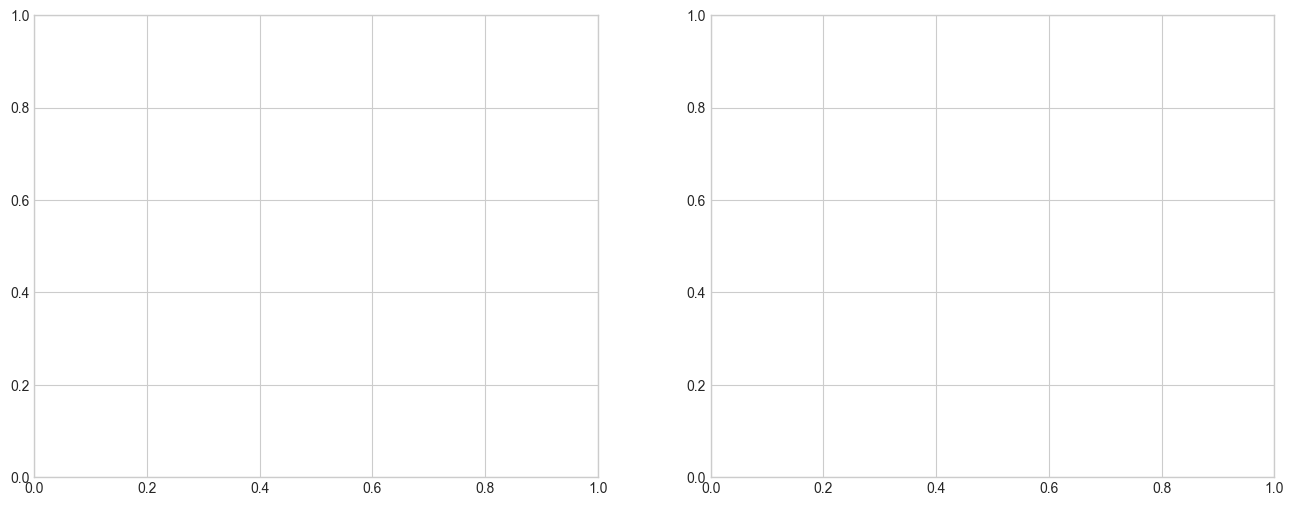

In [ ]:
# --- Plotting the results ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

In [ ]:
# Elbow Method Plot
ax1.plot(K_range, inertia, 'bo-')
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal K')
ax1.grid(True)

# Silhouette Score Plot
ax2.plot(K_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score for Optimal K')
ax2.grid(True)

plt.suptitle('Model Evaluation to Determine Optimal K', fontsize=16)
plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.decomposition import PCA

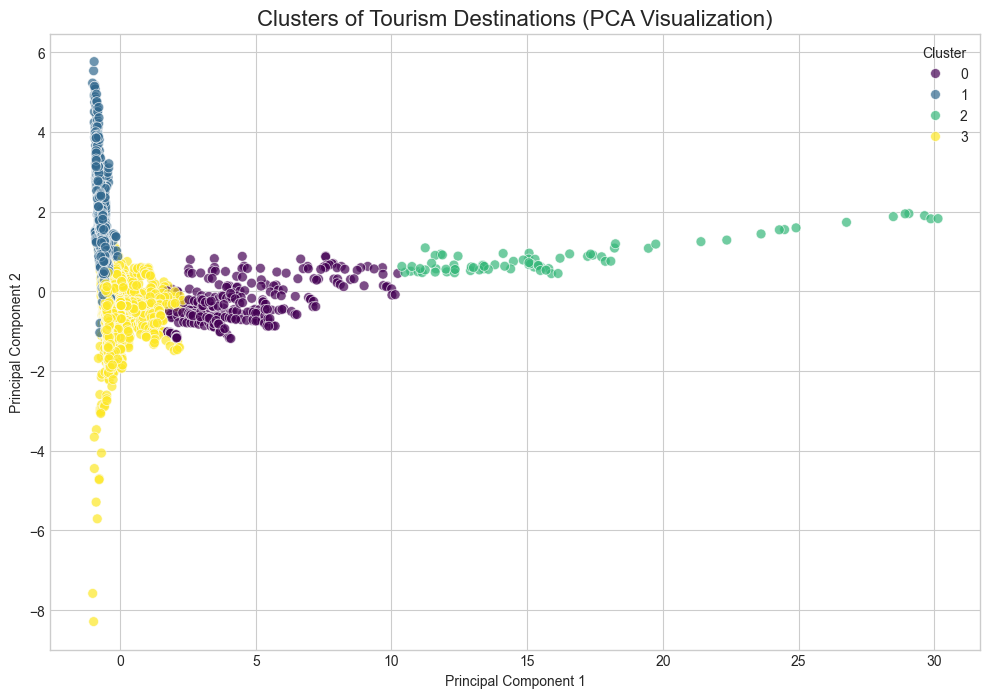

In [ ]:
# --- Apply K-Means with the chosen K ---
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_kmeans)

# --- Use PCA for Dimensionality Reduction & Visualization ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_kmeans)

# Create a DataFrame with PCA results and cluster labels
visual_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
visual_df['Cluster'] = cluster_labels
visual_df['country_code'] = df_country['country_code'].values

# --- Plot the PCA scatter plot of clusters ---
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=visual_df, palette='viridis', s=50, alpha=0.7)
plt.title('Clusters of Tourism Destinations (Country Segments)', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [ ]:
# Attach cluster labels to the country-level table
clustered_countries = df_country.copy()
clustered_countries['Cluster'] = cluster_labels
clustered_countries.head()

In [ ]:
# Cluster interpretation: average profile per cluster
cluster_profiles = (
    clustered_countries
    .groupby('Cluster')[feature_cols]
    .mean()
    .sort_values(by='tourism_arrivals', ascending=False)
)

pd.options.display.float_format = '{:,.2f}'.format
print('Cluster Profiles (mean over period):')
cluster_profiles

Cluster Profiles based on Average Characteristics:


C:\Users\ariaf\AppData\Local\Temp\ipykernel_13668\1599452584.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_original[col].fillna(median_val, inplace=True)
C:\Users\ariaf\AppData\Local\Temp\ipykernel_13668\1599452584.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

,tourism_receipts,tourism_arrivals,gdp,receipts_per_arrival,travel_balance,unemployment
Cluster,,,,,,
2,"1,005,182,181,818.18","1,430,104,576.61","56,088,663,636,363.63",696.67,"1,005,182,181,812.42",6.31
0,"160,666,479,020.98","598,750,486.81","20,081,381,643,356.64",313.78,"160,666,479,015.50",6.40
3,"9,083,845,315.86","21,376,808.52","654,290,403,753.68",797.27,"9,083,845,310.50",7.75
1,"2,431,026,936.02","2,665,139.28","46,099,423,057.74","1,807.21","2,431,026,924.89",9.14


In [ ]:
# Example countries per cluster
print('--- Example Destinations in Each Cluster ---')
for cluster_id in sorted(clustered_countries['Cluster'].unique()):
    countries = clustered_countries[clustered_countries['Cluster'] == cluster_id]['country'].unique()
    example_countries = list(countries)[:8]
    print(f"\nCluster {cluster_id}:")
    print(', '.join(example_countries))


--- Example Destinations in Each Cluster ---

Cluster 0:
Europe & Central Asia, Euro area, European Union, High income, IDA & IBRD total

Cluster 1:
Aruba, Albania, Andorra, Argentina, Antigua and Barbuda

Cluster 2:
World, High income, OECD members, Post-demographic dividend

Cluster 3:
Africa Eastern and Southern, Afghanistan, Africa Western and Central, Angola, Arab World
